#### I. Referencias consultadas

Algebra lineal
+ [Distintas formas de invertir matrices en Julia](https://stanford.edu/class/engr108/lectures/julia_inverses_slides.pdf)

Libería Gridap
+ [Domain Contributions](https://github.com/gridap/Gridap.jl/blob/ba78d8d34207b318dab7251617bdc310f6be26fc/src/CellData/DomainContributions.jl#L2)
+ [MultiField](https://github.com/gridap/Gridap.jl/tree/ba78d8d34207b318dab7251617bdc310f6be26fc/src/MultiField)
+ [FESpaces](https://github.com/gridap/Gridap.jl/tree/ba78d8d34207b318dab7251617bdc310f6be26fc/src/FESpaces)
+ [Tutorials](https://gridap.github.io/Tutorials/dev/)
+ [Community](https://gitter.im/Gridap-jl/community)

Libreria Arpack
+ [API Arpack.eigs](https://arpack.julialinearalgebra.org/stable/api/)
+ [Arpack](https://docs.juliahub.com/Arpack/X5VZL/0.4.0/#lib-itereigen-1)
+ [Eigen value problems](https://doc.freefem.org/models/eigen-value-problems.html)

Libreria SLEPc
+ [GridapPETSc](https://github.com/gridap/GridapPETSc.jl)
+ [Julia wrapper for SLEPc library](https://discourse.julialang.org/t/julia-wrapper-for-slepc-library/54910)
+ [Parallel Julia wrapper for SLEPc library](https://juliahub.com/ui/Packages/SlepcWrap/S3PC8/0.1.2)

Teoría
+ [Gram-Schmidt Procedure](https://tlienart.github.io/posts/2021/06/25-gram-schmidt/)

# Desarrollo numérico para resolver la ecuación de Schrödinger dependiente del tiempo mediante el problema de autovalores

## 1. Importamos módulo con funciones, parámetros y algorítmos útiles

In [1]:
name_code = "01_Code";

In [6]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Creamos propiedades de la grilla

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [3]:
grid_type="simple_line";                            # tipo de grilla
ΔxH=1.0/1500.0;                                      # tamaño del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0414344s, CPU 0.037472s)
Info    : 75001 nodes 75002 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 75001 nodes
Info    : 75002 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_01.msh'


In [4]:
x,pts=space_coord(dom_1D,ΔxH);

## 3. Metodo de autovalores

La idea acá es resolver el problema de autovalores para el hamiltoniano $\hat {h}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

El sistema se reduce a una ecuación de Sturm-Liouville con parámetros $p( x) ,q( x) ,r( x)$ defnidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q( x) =\frac{1}{2} m\omega ^{2}( x-x_{a})^{2}\\
    r( x) =1
    \end{cases} \Rightarrow -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}
\end{align}

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales

Las formas bilineales para considerar el problema débil de autovalores serán de la forma,

\begin{align}
    \begin{array}{l}
    \begin{cases}
    a_{1}( u_{1} ,v_{1}) := \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q( x)( v_{1} u_{1})] d\Omega \\
    a_{2}( u_{2} ,v_{2}) := \int _{\Omega }[ p( x)( \nabla v_{2} \cdotp \nabla u_{2}) +q( x)( v_{2} u_{2})] d\Omega 
    \end{cases}\\
    a(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := a_{1}( u_{1} ,v_{1}) +a_{2}( u_{2} ,v_{2})\\
    \\
    \begin{cases}
    b_{1}( u_{1} ,v_{1}) := \int _{\Omega } r( x)( v_{1} u_{1}) d\Omega ; & b_{2}( u_{2} ,v_{2}) := \int _{\Omega } r( x)( v_{2} u_{2}) d\Omega 
    \end{cases}\\
    b(( u_{1} ,u_{2}) ,( v_{1} ,v_{2})) := b_{1}( u_{1} ,v_{1}) +b_{2}( u_{2} ,v_{2})
    \end{array}
\end{align}

In [7]:
Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);

ω=1.0;  # angular frecuency
x₁=0.0; # center position of HO potential

pₕ,qₕ,rₕ=eigenvalue_problem_functions((ω,x₁,x₂))
aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D);

Set quantum harmonic oscillator 1D potential


Construimos el problema de autovalores, con parámetros específicos de resolución

In [8]:
nevₕ=40; # debe ser múltiplo de 2
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-1.0);

Resolvermos el problema, para obtener autovalores y autoestados

In [9]:
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un único autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneración) los datos obtenidos para no duplicar resultados y quedarnos con sólo aquellos resultados no triviales.

In [10]:
Vₕreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕreim_1D=TrialFESpace(Vₕreim_1D,dirichlet_values_1D);

ϕₕreim_1D=Vector{CellField}(undef,convert(Int32,probₕ_1D.nev/2));

for i in 1:2:probₕ_1D.nev
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[i],probₕ_1D.trial);
    fₕre_1D,fₕim_1D=fₕ_1D;
    ϕₕreim_1D[convert(Int32,(i+1)/2)]=interpolate_everywhere(fₕre_1D+im*fₕim_1D,Uₕreim_1D);
end

Verificamos la normalización de los autoestados, para ello usando la función anterior y deberíamos obtener resultados cercanos a la unidad

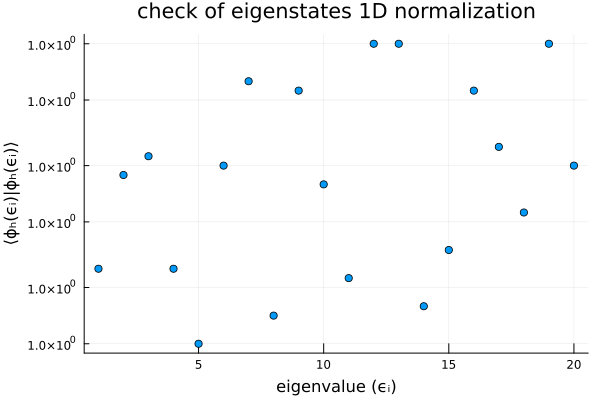

GKS: Possible loss of precision in routine SET_WINDOW


In [11]:
plotting=true
if plotting
    ϕₕreim_1D_norm=normalization_eigenstates_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕₕreim_1D)],ϕₕreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕₕ(ϵᵢ)|ϕₕ(ϵᵢ)⟩")
    plot₁=plot!(title="check of eigenstates 1D normalization")
    display(plot₁)
end

Ahora podemos graficar los diferentes autoestados

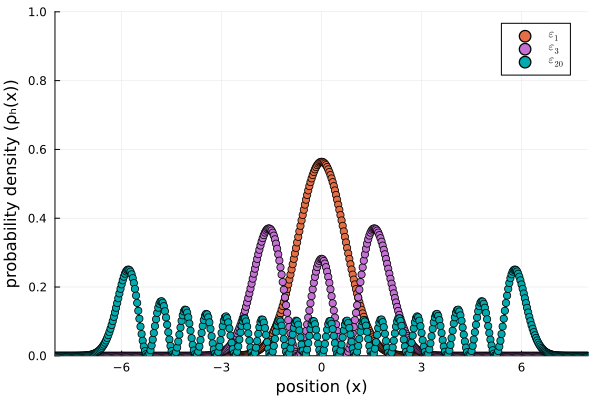

In [12]:
plotting=true
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,3,20]
        ρₕreim_1D=real(conj(ϕₕreim_1D[i].(pts)).*(ϕₕreim_1D[i].(pts)))
        plot1=plot!(x,ρₕreim_1D,label="",lw=2,lc=:"black",ylim=(0,1),xlim=(-8,8))
        plot1=scatter!(x,ρₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,1),xlim=(-8,8))
        plot1=plot!(xlabel="position (x)",ylabel="probability density (ρₕ(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_eigenstates_QHO_individual.pdf");
end

De la misma forma que para los autoestados debemos retener sólo algunos resultados de los autovalores obtenidos, recordando la degeneración de las partes real e imaginaria asociadas a un mismo autoestado.

In [13]:
ϵₕ₁re_1D=ϵₕ_1D[1:2:end]; # vector de autoestados (SIN DEGENERACIÓN)

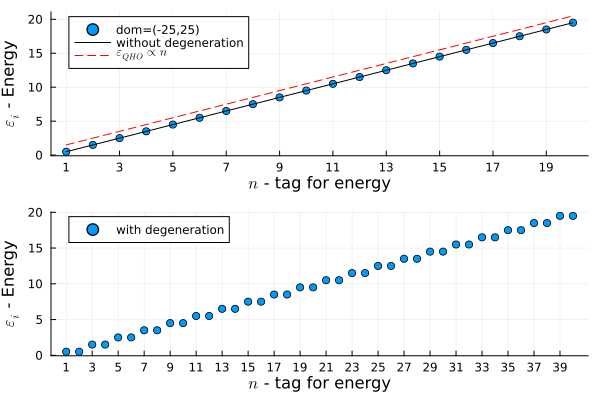

In [14]:
plotting=true
if plotting
    plot1=scatter([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot1=plot!([i for i in 1:nevₕ/2],ϵₕ₁re_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!([i for i in 1:nevₕ/2],(ħ*ω).*([i for i in 1:nevₕ/2].+0.5),label="\$\\epsilon_{QHO} \\propto n\$",lc=:"red",lw=1,ls=:dash);
    plot1=plot!(legend=:topleft)

    plot2=scatter([i for i in 1:nevₕ],ϵₕ_1D,label="with degeneration")
    plot2=plot!(xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot2=plot!(legend=:topleft)

    plot3=plot(plot1,plot2,layout=(2,1))
    # savefig(plot3,path_plots*"eigenvalues_QHO_individual.pdf");
    display(plot3)
end

### 3.2. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$ variando el dominio de resolución

Ahora intentamos testear si el método numérico utilizado es variacional, para ello, calculamos las energías del oscilador armónico cuántico 1D variando el dominio de resolución (ancho $L$ de la caja) y comparando los resultados con las energías exactas.

Información útil para input/output en Julia
+ [https://docs.julialang.org/en/v1/base/io-network/](https://docs.julialang.org/en/v1/base/io-network/)

In [15]:
rm("../outputs/01_Code/energy_vs_domain.dat")
io = open("../outputs/01_Code/energy_vs_domain.dat", "w");
space="  ";
write(io, "#level$(space)ϵ_exact$(space)ϵₕ[au]$(space)1/L[au]\n");

El tamaño del elemento finito se eligio igual a la unidad para que al simular con un dominio $(L_{mín},L_{máx})$ con $L_{mín}=L_{máx}=10$ la cantidad de elementos finitos sea de $\frac{\left| L_{max}-L_{mín} \right|}{\Delta x_{H}}=20 \left[ \mathrm{elementos} \right]$. Se utilizó una baja precisión debido a que la propiedades variacionales no deberían depender de la precisión del método, se requeriría menor tiempo de computo y al existir errores numéricos mayores, en caso de que el método no sea variacional, la evidencia no variacional sería más avidente.

In [16]:
# CREAMOS PROPIEDADES DE LA GRILLA

grid_type="simple_line";    # mesh type
ΔxH=1.0;                    # 2D finite element size

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

reffe_1D=reference_FEspaces(lagrangian,Float64,2);

nevₕ=20; # debe ser múltiplo de 2

for L_index in 1:5

    L=(5.0*L_index); # max range domain
    dom_1D=(-L,L);

    par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

    model_1D=make_model(grid_type,par_1D);              # creamos modelo

    Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

    x,pts=space_coord(dom_1D,ΔxH);

    # RESOLVEMOS PROBLEMA DE AUTOVALORES PARA h
    Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
    Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
    Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
    Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);
    aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D);
    probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-1.0);
    ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

    ϵₕ₁re_1D=ϵₕ_1D[1:2:end]; # vector de autoestados (SIN DEGENERACIÓN)

    for i in 1:length(ϵₕ₁re_1D)
        write(io,"$(i)$(space)$(i-0.5)$(space)$(ϵₕ₁re_1D[i])$(space)$(1.0/L)\n");
    end
end

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000130582s, CPU 0.000129s)
Info    : 11 nodes 12 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 11 nodes
Info    : 12 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_01.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000114572s, CPU 0.000229s)
Info    : 21 nodes 22 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 21 nodes
Info    : 22 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_01.msh'
Info    : Meshing 1D...
In

In [17]:
close(io);

In [18]:
# CONFIGURAMOS INPUT/OUTPU JULIA
rm("../outputs/01_Code/energy_vs_FE.dat")
io_10 = open("../outputs/01_Code/energy_vs_FE.dat", "w");
space="  ";
write(io_10, "#level$(space)ϵ_exact$(space)ϵₕ[au]$(space)ΔxH[au]\n");


# CREAMOS PROPIEDADES DE LA GRILLA

grid_type="simple_line";    # mesh type

dom_1D=(-25.0,25.0);

# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

reffe_1D=reference_FEspaces(lagrangian,Float64,2);

nevₕ=40; # debe ser múltiplo de 2

for ΔxH_index in 1:10

    ΔxH=2.5*(1.0/ΔxH_index); # max range domain

    par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH);    # (path,name,dom,MeshSize)

    model_1D=make_model(grid_type,par_1D);              # creamos modelo

    Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

    # RESOLVEMOS PROBLEMA DE AUTOVALORES PARA h
    Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);
    Vₕim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
    Uₕim_1D=TrialFESpace(Vₕim_1D,dirichlet_values_1D);
    Uₕ_1D = MultiFieldFESpace([Uₕre_1D, Uₕim_1D]);
    Vₕ_1D = MultiFieldFESpace([Vₕre_1D, Vₕim_1D]);
    aₕ_1D,bₕ_1D=bilineal_forms_ReImParts(pₕ,qₕ,rₕ,dΩ_1D);
    probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-1.0);
    ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

    ϵₕ₁re_1D=ϵₕ_1D[1:2:end]; # vector de autoestados (SIN DEGENERACIÓN)

    for i in 1:length(ϵₕ₁re_1D)
        write(io_10,"$(i)$(space)$(i-0.5)$(space)$(ϵₕ₁re_1D[i])$(space)$(ΔxH)\n");
    end
end

close(io_10)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000168543s, CPU 0.000171s)
Info    : 21 nodes 22 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 21 nodes
Info    : 22 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_01.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000338372s, CPU 0.000522s)
Info    : 41 nodes 42 elements
Info    : Writing '../outputs/01_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/01_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/01_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 41 nodes
Info    : 42 elements
Info    : Done reading '../outputs/01_Code/models/simple_line_01.msh'
Info    : Meshing 1D...
In